# Árvore de Decisão

## Carregando Biblioteca

In [6]:
library(repr)
library(caTools)
options(repr.plot.width = 8, repr.plot.height = 8)
#Árvore de Decisão
library(rpart)
library(rpart.plot)
#Preprocessamento
library(CatEncoders)
library(gplots)
#Matricas
library(caret)

## Carregando os dados

In [7]:
df <- read.csv("../datasets/titanic/train.csv", na.strings = '')
head(df)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


## Pré-Processamento de Dados

In [8]:
# Extração de Pronomes
df$Name <- ifelse(grepl(", Mr. ", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Capt", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Don", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Major", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Col", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Dr", df$Name), 'Dr', as.character(df$Name))
df$Name <- ifelse(grepl("Rev", df$Name), 'Rev', as.character(df$Name))
df$Name <- ifelse(grepl("Sir", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Jonkheer", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Dona", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Countess", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mme", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Lady", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mrs", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mlle", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Ms", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Miss", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Master", df$Name), 'Master', as.character(df$Name))

# Categóricas para Numéricas
le_name <- LabelEncoder.fit(unique(df$Name))
df$Name <- transform(le_name, df$Name)

# Substituir valores ausentes/nulos
media <- mean(df$Age, na.rm = TRUE)
df$Age <- ifelse(is.na(df$Age), media, df$Age)

t <- table(df$Embarked)
moda <- names(t[t == max(t)])

df$Embarked <- ifelse(is.na(df$Embarked), as.character(moda), as.character(df$Embarked) )

# Categórico Para numérico
le_sex <- LabelEncoder.fit(unique(df$Sex))
df$Sex <- transform(le_sex, df$Sex)

le_embarked <- LabelEncoder.fit(unique(df$Embarked))
df$Embarked <- transform(le_embarked, df$Embarked)

# Remoção de colunas
df$PassengerId <- NULL
df$Ticket <- NULL
df$Cabin <- NULL

#Escalonamento 
df[, c('Age', 'Fare')] <- scale(df[, c('Age', 'Fare')])

df$Name = factor(df$Name)
df$Pclass = factor(df$Pclass)
df$Sex = factor(df$Sex)
df$Embarked = factor(df$Embarked)

head(df)
str(df)

Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,4,2,-0.5921480,1,0,-0.5021631,3
1,1,5,1,0.6384304,1,0,0.7864036,1
1,3,3,1,-0.2845034,0,0,-0.4885799,3
1,1,5,1,0.4076970,1,0,0.4204941,3
0,3,4,2,0.4076970,0,0,-0.4860644,3
0,3,4,2,0.0000000,0,0,-0.4778481,2


'data.frame':	891 obs. of  9 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name    : Factor w/ 7 levels "1","2","3","4",..: 4 5 3 5 4 4 4 2 5 5 ...
 $ Sex     : Factor w/ 2 levels "1","2": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  -0.592 0.638 -0.285 0.408 0.408 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  -0.502 0.786 -0.489 0.42 -0.486 ...
 $ Embarked: Factor w/ 3 levels "1","2","3": 3 1 3 3 3 2 3 3 3 1 ...


# Divisão dos dados em treino e teste

In [9]:
set.seed(0)
divisao <- sample.split(df$Survived, SplitRatio = 0.75)

treino <- subset(df, divisao == TRUE)
teste <-  subset(df, divisao == FALSE)

x_train <- treino[,-1]
y_train <- treino$Survived

x_test <- teste[,-1]
y_test <- teste$Survived

## Rpart

Argumentos

- **x** - Uma matriz numérica ou um quadro de dados de variáveis  categóricas e/ou numéricas. Mantenha uma cópia da matriz x no resultado.
- **y** - Vetor de classe. Mantenha uma cópia da variável dependente no resultado. Se estiver ausente e o modelo for fornecido, o padrão é FALSE.
- **formula** - Uma fórmula da classe de formulário ~ x1 + x2 +…. Interações não são permitidas. Uma fórmula, com uma resposta, mas sem termos de interação. Se for um quadro de dados, será considerado o quadro do modelo (consulte model.frame).
- **data** - um quadro de dados opcional para interpretar as variáveis nomeadas na fórmula.
- **subset** - Expressão opcional dizendo que apenas um subconjunto das linhas dos dados deve ser usado no ajuste.
- **na.action** - A ação padrão exclui todas as observações para as quais y está faltando, mas mantém aquelas nas quais um ou mais preditores estão faltando.
- **method** - um de "anova", "poisson", "classe" ou "exp". Se o método estiver faltando, a rotina tentará fazer uma suposição inteligente. Se y é um objeto de sobrevivência, então method = "exp" é assumido, se y tem 2 colunas então method = "poisson" é assumido, se y é um fator então method = "class" é assumido, caso contrário method = "anova" é assumido. É mais sensato especificar o método diretamente, especialmente porque mais critérios podem ser adicionados à função no futuro. Alternativamente, o método pode ser uma lista de funções chamadas init, split e eval. Os exemplos são dados no arquivo tests / usersplits.R nas fontes e nas vinhetas ‘Funções de divisão gravadas pelo usuário’.
- **model** - se lógico: manter uma cópia da moldura do modelo no resultado? Se o valor de entrada para o modelo for um quadro de modelo (provavelmente de uma chamada anterior à função rpart), esse quadro é usado em vez de construir novos dados.
- **cost** - um vetor de custos não negativos, um para cada variável do modelo. O padrão é um para todas as variáveis. Essas são escalas a serem aplicadas ao considerar as divisões, portanto, a melhoria na divisão em uma variável é dividida por seu custo na decisão de qual divisão escolher.
- **control** - Uma lista de opções que controlam os detalhes do algoritmo rpart. Veja rpart.control.
- **params** - parâmetros opcionais para a função de divisão. A divisão Anova não tem parâmetros. A divisão de Poisson tem um único parâmetro, o coeficiente de variação da distribuição anterior nas taxas. O valor padrão é 1. A divisão exponencial tem o mesmo parâmetro de Poisson. Para a divisão de classificação, a lista pode conter qualquer um dos seguintes: o vetor de probabilidades anteriores (componente anterior), a matriz de perda (perda de componente) ou o índice de divisão (divisão de componente). Os antecedentes devem ser positivos e somam 1. A matriz de perda deve ter zeros na diagonal e elementos fora da diagonal positivos. O índice de divisão pode ser gini ou informações. Os padrões anteriores são proporcionais às contagens de dados, o padrão de perdas é 1 e o padrão de divisão é gini.

## Controle da Árvore

- **minplit** - O número mínimo de observações que devem existir em um nó para que uma divisão seja tentada.
- **minbucket** - O número mínimo de observações em qualquer nó terminal \<leaf>. Se apenas um de minbucket ou minsplit for especificado, o código define minsplit para minbucket * 3 ou minbucket para minsplit / 3, conforme apropriado.
- **cp** -  Parâmetro de complexidade. Qualquer divisão que não diminua a falta de ajuste geral por um fator de cp não é tentada. Por exemplo, com a divisão de anova, isso significa que o R-quadrado geral deve aumentar em cp em cada etapa. A principal função desse parâmetro é economizar tempo de computação eliminando divisões que obviamente não valem a pena. Essencialmente, o usuário informa ao programa que qualquer divisão que não melhore o ajuste por cp provavelmente será eliminada por validação cruzada e que, portanto, o programa não precisa persegui-la.
- **maxcompete** - O número de divisões do concorrente retido na saída. É útil saber não apenas qual divisão foi escolhida, mas qual variável veio em segundo, terceiro, etc.
- **maxsurrogate** - O número de divisões substitutas retidas na saída. Se for definido como zero, o tempo de cálculo será reduzido, uma vez que aproximadamente metade do tempo de cálculo (além da configuração) é usado na pesquisa de divisões substitutas.
- **usesurrogate** - Como usar substitutos no processo de divisão. 0 significa apenas exibição; uma observação com um valor ausente para a regra de divisão primária não é enviada mais adiante na árvore. 1 significa usar substitutos, em ordem, para dividir os sujeitos sem a variável primária; se faltarem todos os substitutos, a observação não é dividida. Para o valor 2, se todos os substitutos estiverem faltando, envie a observação na direção da maioria. O valor 0 corresponde à ação da árvore e 2 às recomendações de Breiman et.al (1984).
- **xval** - Número de validações cruzadas.
- **surrogatestyle** - Controla a seleção de um melhor substituto. Se definido como 0 (padrão), o programa usa o número total de classificações corretas para uma variável substituta potencial; se definido como 1, ele usa o percentual correto, calculado sobre os valores não omissos do substituto. A primeira opção penaliza mais severamente as covariáveis com um grande número de valores ausentes.
- **maxdepth** - Profundidade máxima. Defina a profundidade máxima de qualquer nó da árvore final, com o nó raiz contado como profundidade 0. Valores maiores que 30 rpart darão resultados absurdos em máquinas de 32 bits.

In [10]:
x <- cbind(x_train, y_train)

classificador <- rpart(y_train ~ ., data = x, method = 'class')

## Exibir o Gráfico de Decisção

- **plot**
- **text**
- **rpart.plot**
- **summary**

In [11]:
classificador

n= 668 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 668 256 0 (0.61676647 0.38323353)  
    2) Name=4,6 402  61 0 (0.84825871 0.15174129)  
      4) Fare< -0.1194415 301  29 0 (0.90365449 0.09634551) *
      5) Fare>=-0.1194415 101  32 0 (0.68316832 0.31683168)  
       10) Fare>=-0.109254 87  22 0 (0.74712644 0.25287356) *
       11) Fare< -0.109254 14   4 1 (0.28571429 0.71428571) *
    3) Name=1,2,3,5,7 266  71 1 (0.26691729 0.73308271)  
      6) Pclass=3 117  58 0 (0.50427350 0.49572650)  
       12) Fare>=-0.1711335 30   3 0 (0.90000000 0.10000000) *
       13) Fare< -0.1711335 87  32 1 (0.36781609 0.63218391)  
         26) Age>=0.03079839 13   4 0 (0.69230769 0.30769231) *
         27) Age< 0.03079839 74  23 1 (0.31081081 0.68918919)  
           54) Fare>=-0.4893345 48  19 1 (0.39583333 0.60416667)  
            108) Fare< -0.4500516 14   4 0 (0.71428571 0.28571429) *
            109) Fare>=-0.4500516 34   9 1 (0.26470588 0.73529412) *
      

In [12]:
summary(classificador)

Call:
rpart(formula = y_train ~ ., data = x, method = "class")
  n= 668 

          CP nsplit rel error    xerror       xstd
1 0.48437500      0 1.0000000 1.0000000 0.04908405
2 0.04687500      1 0.5156250 0.5273438 0.04054173
3 0.01953125      3 0.4218750 0.4570312 0.03837431
4 0.01171875      4 0.4023438 0.4648438 0.03863060
5 0.01000000      8 0.3554688 0.4453125 0.03798211

Variable importance
    Name      Sex     Fare    Parch    SibSp      Age   Pclass Embarked 
      28       24       14        9        8        8        7        1 

Node number 1: 668 observations,    complexity param=0.484375
  predicted class=0  expected loss=0.3832335  P(node) =1
    class counts:   412   256
   probabilities: 0.617 0.383 
  left son=2 (402 obs) right son=3 (266 obs)
  Primary splits:
      Name     splits as  RRRLRLR, improve=108.199100, (0 missing)
      Sex      splits as  RL, improve=103.594100, (0 missing)
      Pclass   splits as  RRL, improve= 36.127330, (0 missing)
      Fare     < 

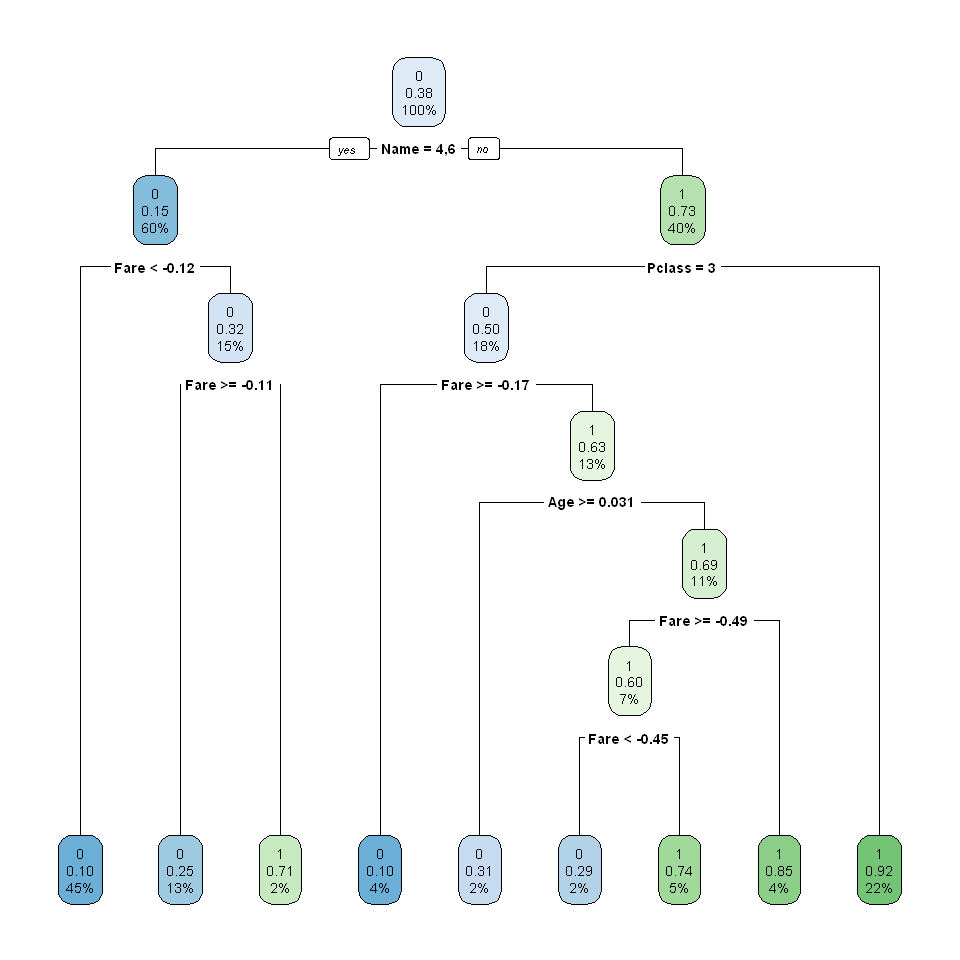

In [13]:
rpart.plot(classificador)

# Prever um valor

- Pode prever uma classe especificando **tupe = 'class'**
- Caso seja omitido irá prever a probabildiade por cada classe

In [14]:
Pclass <- 1
Name <- 'Miss'
Sex <- 'female'
Age <- 5
SibSp <- 1
Parch <- 1
Fare <- 500
Embarked <- 'C'

data = data.frame(Pclass, Name, Sex, Age, SibSp, Parch, Fare, Embarked)

#Tratando os Dados
# Categóricas para Numéricas

data$Name <- transform(le_name, as.character(data$Name))
data$Sex  <- transform(le_sex, (data$Sex))
data$Embarked <- transform(le_embarked, as.character(data$Embarked))

data$Name = factor(data$Name)
data$Pclass = factor(data$Pclass)
data$Sex = factor(data$Sex)
data$Embarked = factor(data$Embarked)

data[, c('Age', 'Fare')] <- scale(data[, c('Age', 'Fare')])

#Classificando
previsao = predict(classificador, newdata = data, type = 'class')
previsao

1 
1 
Levels: 0 1

## Prever os dados de Teste

In [15]:
previsao = predict(classificador, newdata = x_test, type = 'class')

acuracia = 100 * sum(previsao == y_test)/length(y_test)

acuracia

[1] 79.82063

# Matriz de Confusão

- A função **table** realiza o agrupamento dos dados
- A função **confusionMatriz** da biblioteca **caret** também calcula a matriz de confusão + as métricas

In [16]:
matriz_confusao = table(y_test, previsao)
matriz_confusao

      previsao
y_test   0   1
     0 117  20
     1  25  61

In [17]:
matriz = confusionMatrix(factor(previsao), factor(y_test))
matriz

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 117  25
         1  20  61
                                          
               Accuracy : 0.7982          
                 95% CI : (0.7395, 0.8488)
    No Information Rate : 0.6143          
    P-Value [Acc > NIR] : 2.877e-09       
                                          
                  Kappa : 0.5695          
                                          
 Mcnemar's Test P-Value : 0.551           
                                          
            Sensitivity : 0.8540          
            Specificity : 0.7093          
         Pos Pred Value : 0.8239          
         Neg Pred Value : 0.7531          
             Prevalence : 0.6143          
         Detection Rate : 0.5247          
   Detection Prevalence : 0.6368          
      Balanced Accuracy : 0.7817          
                                          
       'Positive' Class : 0               
                              

## Personalizando a Matriz de Confusão

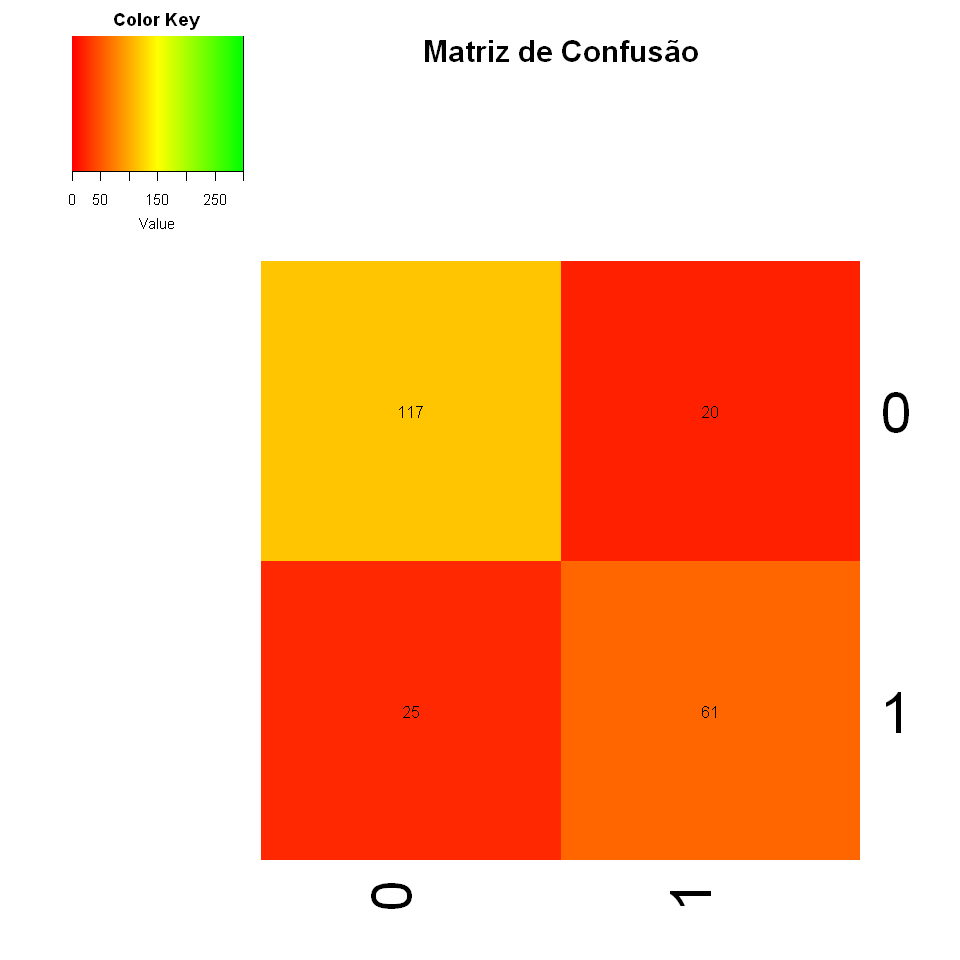

In [18]:
my_palette <- colorRampPalette(c("red", "yellow", "green"))

col_breaks = c(0:50, 51:100, 101:300)

heatmap.2(matriz_confusao,
    Rowv = 'NA',
    cellnote = matriz_confusao, 
    main = "Matriz de Confusão",
    notecol="black",      
    density.info="none",  
    trace="none",        
    col=my_palette,       
    breaks=col_breaks,   
    dendrogram= 'none',     
    Colv="NA" 
)

# Métricas

- **Precisão** que é a fração de instâncias recuperadas que são relevantes, 
- **Recall** - que é a fração de instâncias relevantes que são recuperadas 
- **f-score** - é 2 * precisão * recall / (precisão + recall) é 

In [19]:
precision(factor(previsao), factor(y_test))
'Morto'
precision(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
precision(factor(previsao), factor(y_test), relevant = 1)

[1] 0.8239437

[1] "Morto"

[1] 0.7530864

[1] "Vivo"

[1] 0.8239437

In [20]:
recall(factor(previsao), factor(y_test))
'Morto'
recall(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
recall(factor(previsao), factor(y_test), relevant = 1)

[1] 0.8540146

[1] "Morto"

[1] 0.7093023

[1] "Vivo"

[1] 0.8540146

In [21]:
F_meas(factor(previsao), factor(y_test))
'Morto'
F_meas(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
F_meas(factor(previsao), factor(y_test), relevant = 1)

[1] 0.8387097

[1] "Morto"

[1] 0.7305389

[1] "Vivo"

[1] 0.8387097

# Poder a Árvore

- Podemos definir uma profundidade e erro na contrução do classificador
- Para fazer a poda de um classificador já contruído devemos usar a função **prune** e especificar a complexidade.
- Para encontrar o menor erro possível usamos o **cptable**

In [22]:
poda = prune(classificador, cp = 0.1)

previsao = predict(poda, newdata = x_test, type = 'class')
acuracia = 100 * sum(previsao == y_test)/length(y_test)
acuracia

[1] 75.33632

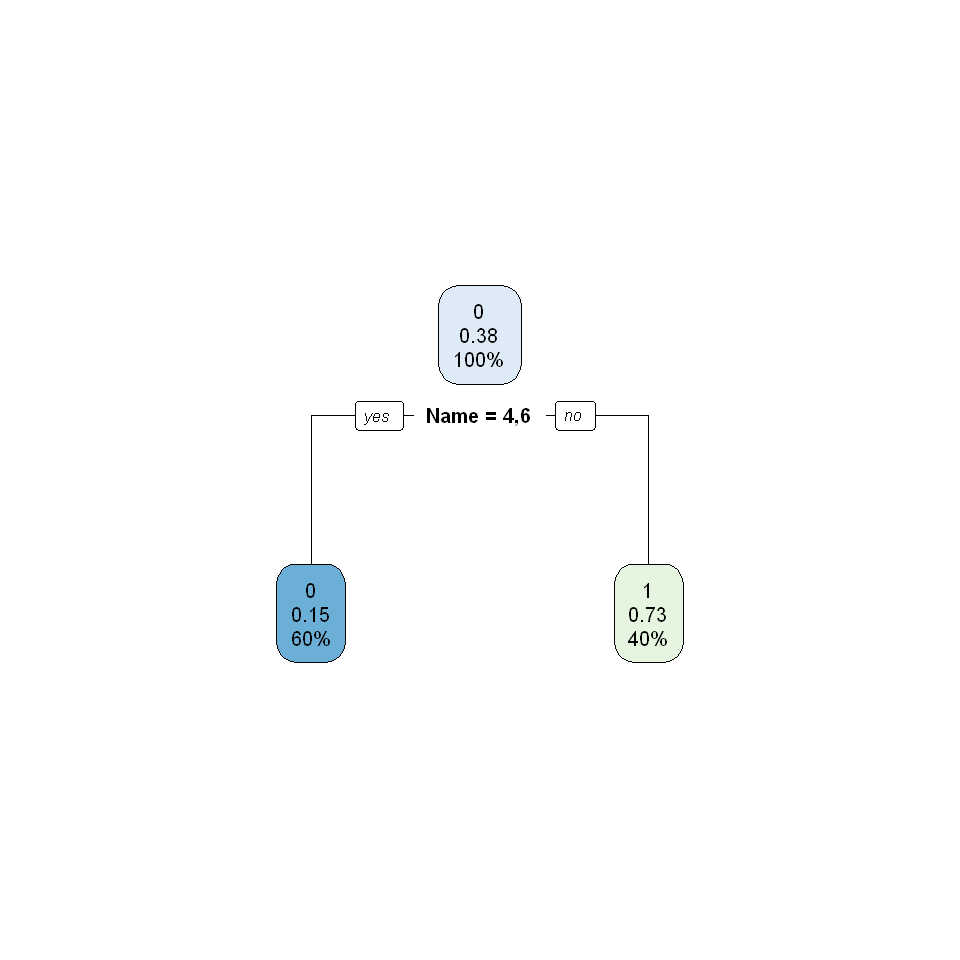

In [23]:
rpart.plot(poda)

In [24]:
cp = classificador$cptable[which.min(classificador$cptable[,"xerror"]), "CP"]
poda = prune(classificador, cp = 0.0009)

previsao = predict(poda, newdata = x_test, type = 'class')
acuracia = 100 * sum(previsao == y_test)/length(y_test)
acuracia

[1] 79.82063

# Validação Cruzada

- **method = cv** - indica que iremos usar o método crossvalidation
- **number = 10** - define o número de fold
- **method = rpart** - indica que iremos usar o algorítmo árvores de Decisão

In [30]:
controle_treinamento = trainControl(method = 'cv', number = 10)
df$Survived = factor(df$Survived)
modelo = train(Survived ~ ., data = df, trControl = controle_treinamento, method = 'rpart')
modelo$results

cp,Accuracy,Kappa,AccuracySD,KappaSD
0.01461988,0.8180774,0.6085040,0.05149845,0.1153241
0.05263158,0.7833084,0.5420961,0.04736588,0.1029624
0.43567251,0.6959426,0.2850658,0.07385894,0.2484823
